In [1]:
# Load libraries

from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [2]:
# Load minute weather data

sqlContext = SQLContext(sc)
df = spark.read.format("csv").option("header","true").option("inferSchema","true").load("file:/home/mhnguyen/projects/teaching/SI2017/sparkml/minute_weather.csv") 

In [3]:
# Count rows

df.count()

1587257

In [4]:
# Filter rows

filteredDF = df.filter((df.rowID % 100) == 0)
filteredDF.count()

15873

In [5]:
# Show summary statistics

filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,15873,793600.0,458228.4746717515,0,1587200
air_pressure,15873,916.8291627291625,3.05172221517962,905.1,929.4
air_temp,15873,61.854689094689114,11.835413790821471,32.36,96.44
avg_wind_direction,15870,161.2875236294896,95.31316129656489,0.0,359.0
avg_wind_speed,15870,2.7928040327662256,2.070506198460019,0.1,20.1
max_wind_direction,15870,162.70094517958412,92.26960112663161,0.0,359.0
max_wind_speed,15870,3.4146250787649652,2.4289064068121347,0.1,20.9
min_wind_direction,15870,166.64429741650915,97.8248363068251,0.0,359.0
min_wind_speed,15870,2.15226843100189,1.7581135042599594,0.0,19.5


In [6]:
# Drop null data

workingDF = filteredDF.na.drop()
workingDF.count()

15869

In [7]:
# Create feature vector

featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [8]:
# Scale data

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [9]:
# Use one-third data for elbow plot

scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()
elbowset.count()

5289

In [10]:
# Generate clusters for elbow plot

clusters = range(5,20)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 5 
......................WSSE = 8804.075943656197 
Training for cluster size 6 
......................WSSE = 8498.98531620898 
Training for cluster size 7 
......................WSSE = 8193.268619464267 
Training for cluster size 8 
......................WSSE = 8004.583031668283 
Training for cluster size 9 
......................WSSE = 7693.664086684701 
Training for cluster size 10 
......................WSSE = 7407.674964498868 
Training for cluster size 11 
......................WSSE = 7317.489395066483 
Training for cluster size 12 
......................WSSE = 7057.669803649447 
Training for cluster size 13 
......................WSSE = 7085.278395402496 
Training for cluster size 14 
......................WSSE = 6847.30285586511 
Training for cluster size 15 
......................WSSE = 6673.815480080208 
Training for cluster size 16 
......................WSSE = 6663.40844875642 
Training for cluster size 17 
......................WSSE = 6504.85598722

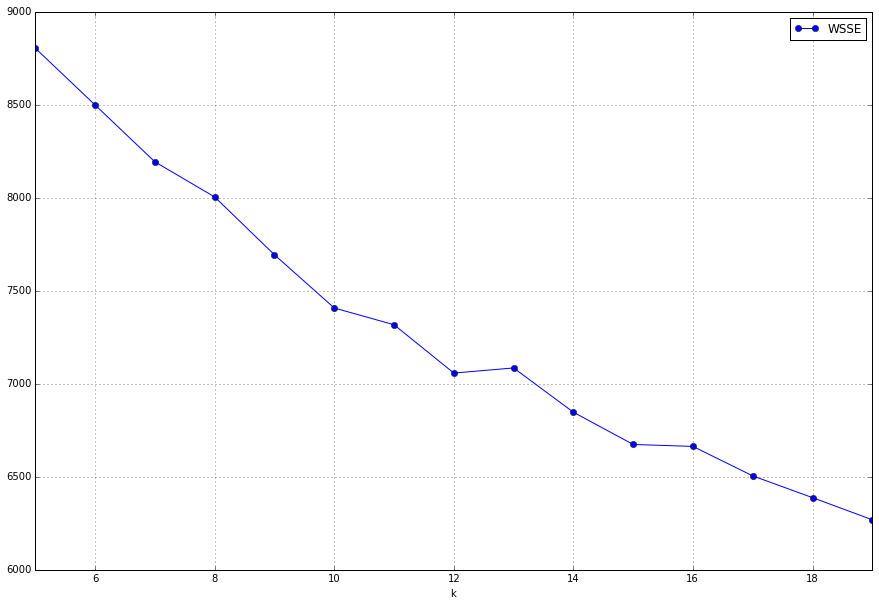

In [11]:
# Show elbow plot

utils.elbow_plot(wsseList, clusters)

In [12]:
# Run KMeans for k = 12

scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [13]:
# Compute cluster centers

centers = model.clusterCenters()
P = utils.pd_centers(featuresUsed, centers)
centers

[array([-0.43576262,  0.31193203,  0.43969083,  1.08419087,  0.53913355,
         1.02111176,  0.01175345]),
 array([-0.17209713,  0.63351831,  0.25934103, -0.46022844,  0.41860009,
        -0.4759387 , -0.39386849]),
 array([ 0.36006628, -0.98071255,  1.88242897, -0.71784684, -1.51667505,
        -0.63265009,  0.89945874]),
 array([ 0.196077  , -0.94783243,  0.61627259, -0.52637461,  0.82235445,
        -0.51578197,  1.13903833]),
 array([-0.10190485,  0.81551771, -1.2865485 , -0.58864696, -1.14541378,
        -0.6021524 , -0.6563763 ]),
 array([ 0.30428879,  0.75864631,  1.32705076, -0.63793148,  1.60658027,
        -0.59373736, -0.74369235]),
 array([-1.43897147, -1.31072803,  0.39187564,  2.17516468,  0.50084525,
         2.13271695,  1.39653646]),
 array([ 1.47093374, -0.1039351 , -1.08857523,  0.10352302, -0.9562085 ,
         0.13057971, -1.03369799]),
 array([ 1.15232032, -0.27714833, -1.14092239,  2.29067861, -1.04279252,
         2.41445042, -1.13794194]),
 array([ 0.10922339

## Dry Days

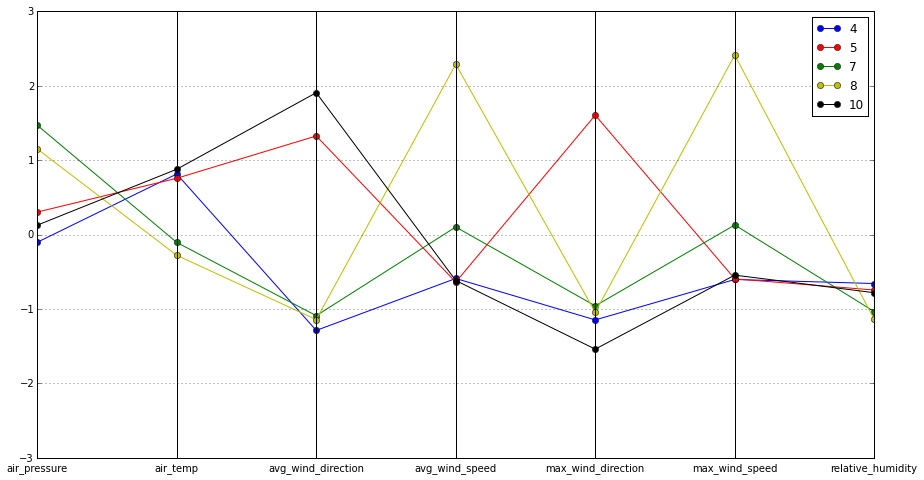

In [14]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

## Humid Days

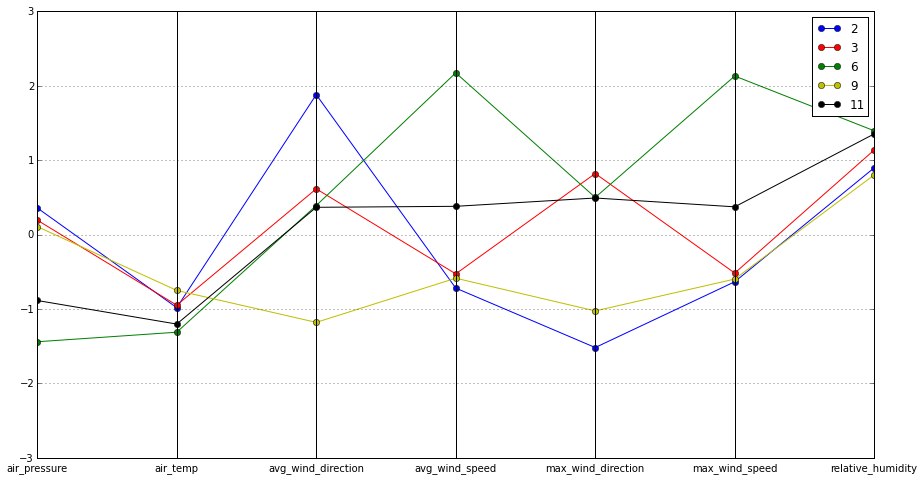

In [15]:
utils.parallel_plot(P[P['relative_humidity'] > 0.5], P)

## Hot Days

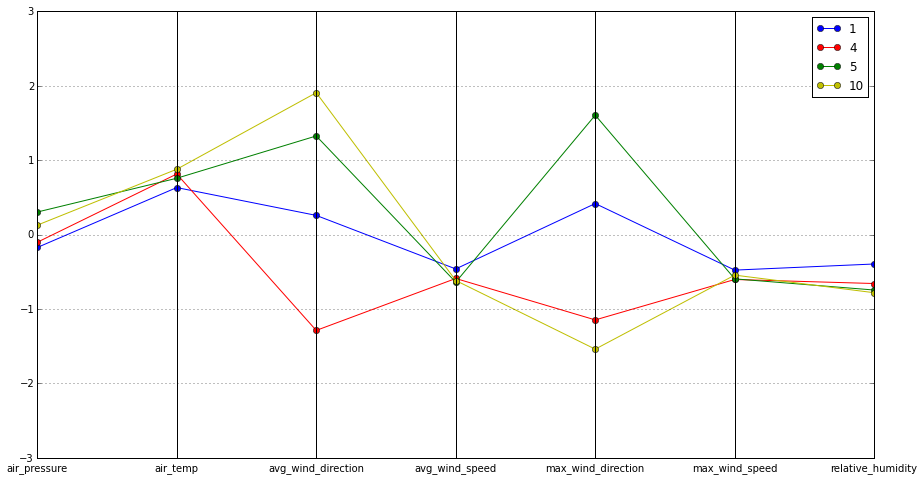

In [16]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

## Cool Days

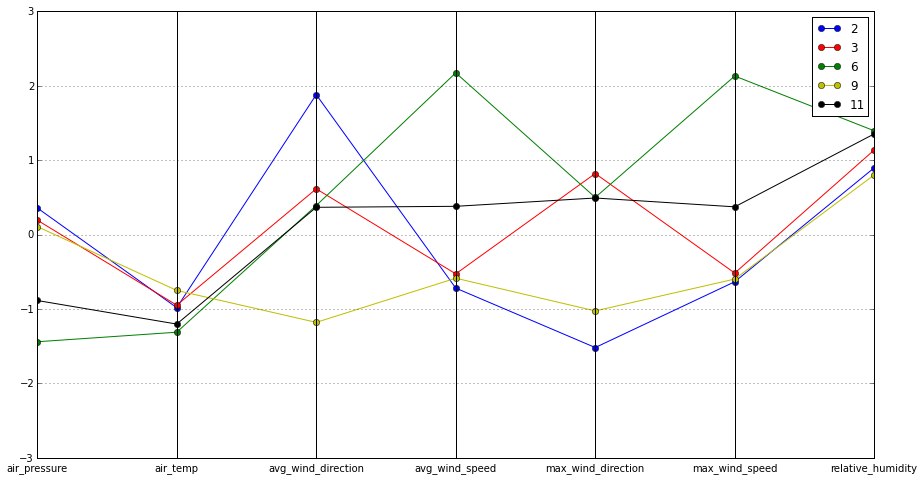

In [17]:
utils.parallel_plot(P[P['air_temp'] < -0.5], P)